# PCL Experiment Notebook

Train algorithms on increasing dataset sizes and plot risk/likelihood.

## Setup

Environment, imports, device selection, and reproducibility seeds.

In [1]:
# Imports and path setup
import sys
from pathlib import Path
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

# Add project root to path if needed (before importing project modules)
sys.path.append(str(Path('..').resolve()))

from subpopbench.dataset import datasets
from subpopbench.learning import algorithms
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from itertools import cycle
from subpopbench import hparams_registry
from subpopbench.utils.eval_helper import eval_metrics

# Select device: use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(0)

Using device: cuda


In [2]:
# Utility functions for robust error handling
import logging
import warnings

# Configure logging for better error tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def safe_tensor_operation(func, *args, default_value=None, error_msg="Tensor operation failed"):
    """Safely execute tensor operations with error handling"""
    try:
        result = func(*args)
        # Check if result contains NaN or inf
        if hasattr(result, 'isnan'):
            if result.isnan().any() or result.isinf().any():
                logger.warning(f"{error_msg}: Result contains NaN/inf values")
                return default_value
        return result
    except Exception as e:
        logger.warning(f"{error_msg}: {str(e)}")
        return default_value

def safe_model_operation(model, operation, *args, **kwargs):
    """Safely execute model operations (forward pass, loss computation, etc.)"""
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning)
            return operation(*args, **kwargs)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            logger.error(f"CUDA out of memory during model operation: {e}")
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        else:
            logger.error(f"Runtime error during model operation: {e}")
        return None
    except Exception as e:
        logger.error(f"Unexpected error during model operation: {e}")
        return None

def check_data_validity(data_tuple, expected_length=4):
    """Check if data tuple is valid and contains expected number of elements"""
    try:
        if len(data_tuple) != expected_length:
            logger.warning(f"Data tuple has unexpected length: {len(data_tuple)} (expected {expected_length})")
            return False
        
        for i, item in enumerate(data_tuple):
            if item is None:
                logger.warning(f"Data tuple element {i} is None")
                return False
            
            # Check for tensor validity
            if hasattr(item, 'isnan'):
                if item.isnan().any():
                    logger.warning(f"Data tuple element {i} contains NaN values")
                    return False
        
        return True
    except Exception as e:
        logger.warning(f"Error checking data validity: {e}")
        return False

print("Utility functions for robust error handling loaded successfully.")

Utility functions for robust error handling loaded successfully.


## Experiment configuration

Dataset choice, learners, and result containers.

In [3]:
# Experiment config
DATASET_NAME = 'CMNIST'
DATA_PATH = '/home/mila/t/tom.marty/scratch/data/benchmark'
LEARNERS = ['GroupDRO','ERM','CRT', 'DFR', 'IRM','ReSample']  # invariant learners to compare
NETWORK_NAME = 'ResNet'  # used in title; Algorithm builds its own network

# Toggle: use stratified (label, attr) sampling for each subset size such that the class ratio is preserved
USE_STRATIFIED = True

# Define dataset sizes: 10 -> 30000 (log scale)
dataset_sizes = np.logspace(2, 4.5, num=5, dtype=int).tolist()
#dataset_sizes = np.logspace(2, 2, num=1, dtype=int).tolist()

print('Config:')
print(f'  Dataset: {DATASET_NAME}')
print(f'  Learners: {LEARNERS}')
print(f'  Data path: {DATA_PATH}')
print(f'  Train sizes: {dataset_sizes}')
print(f'  Stratified sampling: {USE_STRATIFIED}')

# Early stopping configuration
ES_PATIENCE = 3         # checkpoints without improvement before stopping
ES_MIN_DELTA = 0.0       # minimum improvement to reset 


# Prepare per-learner results storage
val_loss_map = {alg: [] for alg in LEARNERS}           # validation loss means (best)
train_loss_map = {alg: [] for alg in LEARNERS}        # training loss mean (per size)
test_loss_map  = {alg: [] for alg in LEARNERS}        # test loss means (final model)
test_acc_map = {alg: [] for alg in LEARNERS}          # test accuracy
worst_group_acc_map = {alg: [] for alg in LEARNERS}   # test worst-group accuracy


Config:
  Dataset: CMNIST
  Learners: ['GroupDRO', 'ERM', 'CRT', 'DFR', 'IRM', 'ReSample']
  Data path: /home/mila/t/tom.marty/scratch/data/benchmark
  Train sizes: [100, 421, 1778, 7498, 31622]
  Stratified sampling: True


In [4]:
# Robust training configuration
ROBUST_TRAINING = True  # Enable robust error handling
MAX_RETRIES = 3  # Maximum number of retries for failed operations
CONTINUE_ON_ERROR = True  # Continue with next algorithm/size if current fails
SAVE_PARTIAL_RESULTS = True  # Save results even if some experiments fail

# Enhanced error tracking
ERROR_LOG = {
    'algorithm_failures': {},
    'size_failures': {},
    'step_failures': {},
    'validation_failures': {},
    'test_failures': {}
}

def log_error(error_type, context, error_msg):
    """Log errors for analysis"""
    if error_type not in ERROR_LOG:
        ERROR_LOG[error_type] = {}
    
    key = str(context)
    if key not in ERROR_LOG[error_type]:
        ERROR_LOG[error_type][key] = []
    
    ERROR_LOG[error_type][key].append(error_msg)
    logger.error(f"[{error_type}] {context}: {error_msg}")

def print_error_summary():
    """Print summary of all errors encountered"""
    print("\n=== Error Summary ===")
    total_errors = 0
    for error_type, errors in ERROR_LOG.items():
        if errors:
            print(f"\n{error_type.replace('_', ' ').title()}:")
            for context, error_list in errors.items():
                print(f"  {context}: {len(error_list)} errors")
                total_errors += len(error_list)
    
    if total_errors == 0:
        print("No errors encountered!")
    else:
        print(f"\nTotal errors: {total_errors}")

print(f"Robust training configuration loaded. Robust mode: {ROBUST_TRAINING}")

Robust training configuration loaded. Robust mode: True


## Hyperparameters

Defaults and dataset-specific overrides.

In [5]:
# Hyperparameters template
# We'll derive specific hparams per learner in the training loop
base_hparams = hparams_registry.default_hparams('ERM', DATASET_NAME)
base_hparams.update({
    'image_arch': 'resnet_sup_in1k',
    'text_arch': 'bert-base-uncased',
})
if DATASET_NAME == 'CMNIST':
    base_hparams.update({
        'cmnist_label_prob': 0.5,
        'cmnist_attr_prob': 0.5, # attribute imbalance
        'cmnist_spur_prob': 0.1, #group imbalance : 0.5 means no spurrious correlation 
        'cmnist_flip_prob': 0.0,
    })

print('Hparams template (subset):')
for k in ['image_arch', 'text_arch']:
    print(f'  {k}: {base_hparams[k]}')

Hparams template (subset):
  image_arch: resnet_sup_in1k
  text_arch: bert-base-uncased


## Datasets

Load train/val/test splits and preview samples.

Datasets:
  Train size: 30000 | Val size: 5000 | Test size: 20000 (restricted)
  Input shape: (3, 224, 224) | data_type: images
  num_labels: 2 | num_attributes: 2


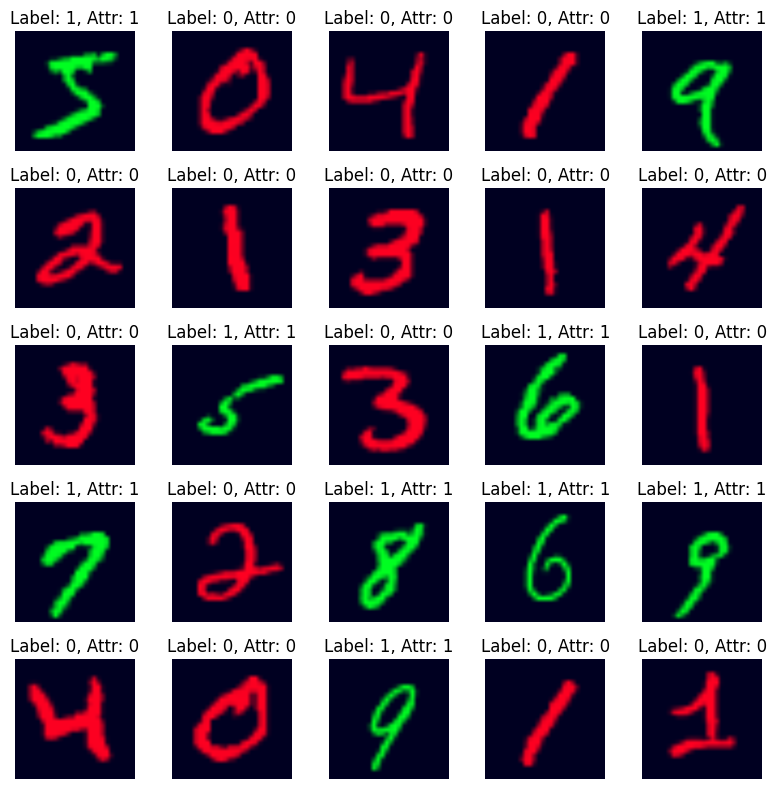

In [6]:
# Datasets
DatasetClass = getattr(datasets, DATASET_NAME)
train_dataset = DatasetClass(DATA_PATH, 'tr', base_hparams)
val_dataset_full = DatasetClass(DATA_PATH, 'va', base_hparams)
test_dataset = DatasetClass(DATA_PATH, 'te', base_hparams)

val_count = min(5000, len(val_dataset_full))
val_indices = random.sample(range(len(val_dataset_full)), val_count)
val_dataset = Subset(val_dataset_full, val_indices)


indices = list(range(len(train_dataset)))
random.shuffle(indices)

print('Datasets:')
print(f'  Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)} (restricted)')
print(f'  Input shape: {train_dataset.INPUT_SHAPE} | data_type: {getattr(train_dataset, "data_type", "images")}')
print(f'  num_labels: {train_dataset.num_labels} | num_attributes: {train_dataset.num_attributes}')

# Preview a few samples (images only)
if getattr(train_dataset, 'data_type', 'images') == 'images':
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    axes = axes.flatten()

    for k, ax in enumerate(axes):
        idx, x, y, a = train_dataset[k]
        # Scale per-image to [0,1] for visualization
        x_vis = x.detach().cpu()
        x_min, x_max = x_vis.min(), x_vis.max()
        x_vis = (x_vis - x_min) / (x_max - x_min + 1e-6)
        ax.imshow(x_vis.permute(1, 2, 0))
        ax.set_title(f'Label: {int(y)}, Attr: {int(a)}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Non-image dataset preview omitted.')

In [7]:
# Stratified sampling helpers (by (label, attr))
from collections import defaultdict

def build_group_index(ds):
    groups = defaultdict(list)
    ys = getattr(ds, 'labels', None)
    attrs = getattr(ds, 'attributes', None)
    if ys is not None and attrs is not None and len(ys) == len(ds) and len(attrs) == len(ds):
        for i in range(len(ds)):
            y_i = int(ys[i])
            a_i = int(attrs[i])
            groups[(y_i, a_i)].append(i)
    else:
        for i in range(len(ds)):
            try:
                _, _, y, a = ds[i]
                groups[(int(y), int(a))].append(i)
            except Exception:
                pass
    return groups

def w(groups, size, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    total = sum(len(ixs) for ixs in groups.values())
    if total == 0:
        return []
    desired = {}
    fracs = {}
    for g, ixs in groups.items():
        c = size * (len(ixs) / total)
        desired[g] = int(np.floor(c))
        fracs[g] = c - desired[g]
    rem = size - sum(desired.values())
    if rem > 0:
        for g in sorted(groups.keys(), key=lambda g: fracs[g], reverse=True)[:rem]:
            desired[g] += 1
    selected = []
    for g, k in desired.items():
        if k <= 0:
            continue
        ixs = groups[g]
        if k >= len(ixs):
            selected.extend(ixs)
        else:
            chosen = rng.choice(ixs, size=k, replace=False).tolist()
            selected.extend(chosen)
    random.shuffle(selected)
    return selected

if USE_STRATIFIED:
    group_to_indices = build_group_index(train_dataset)
    print('Stratified groups (counts):', {k: len(v) for k, v in sorted(group_to_indices.items())})

Stratified groups (counts): {(0, 0): 13849, (0, 1): 1482, (1, 0): 1480, (1, 1): 13189}


### Stratified Sampling
If `USE_STRATIFIED` is True, each training subset for a given size is drawn approximately proportional to the (label, attr) group counts in the full training set using the helper `w(...)`. This helps maintain group balance across different subset sizes. Set `USE_STRATIFIED = False` to revert to the earlier simple prefix-based random subset selection.


In [8]:
# Sanity check: group coverage in splits
from collections import Counter

def group_counts(ds, name='dataset', max_items=None):
    attr_counter = Counter()
    label_counter = Counter()
    pair_counter = Counter()
    n = len(ds) if max_items is None else min(len(ds), max_items)
    for k in range(n):
        try:
            idx, x, y, a = ds[k]
        except Exception as e:
            print(f'[{name}] Could not read item {k}: {e}')
            break
        y_i = int(y)
        a_i = int(a)
        attr_counter[a_i] += 1
        label_counter[y_i] += 1
        pair_counter[(y_i, a_i)] += 1
    print(f'[{name}] size={len(ds)} | unique attrs={sorted(attr_counter.keys())} | unique labels={sorted(label_counter.keys())}')
    print(f'[{name}] attr counts: {dict(sorted(attr_counter.items()))}')
    print(f'[{name}] label counts: {dict(sorted(label_counter.items()))}')
    print(f'[{name}] (label, attr) counts: {dict(sorted(pair_counter.items()))}')
    # Expected coverage checks
    num_attrs = getattr(ds, "num_attributes", getattr(train_dataset, "num_attributes", None))
    num_labels = getattr(ds, "num_labels", getattr(train_dataset, "num_labels", None))
    if num_attrs is not None:
        missing_attrs = [a for a in range(int(num_attrs)) if a not in attr_counter]
        if missing_attrs:
            print(f'WARNING: Missing attrs in {name}: {missing_attrs}')
    if num_labels is not None:
        missing_labels = [y for y in range(int(num_labels)) if y not in label_counter]
        if missing_labels:
            print(f'WARNING: Missing labels in {name}: {missing_labels}')
    return attr_counter, label_counter, pair_counter

# Run group coverage checks
# _ = group_counts(train_dataset, 'train')
# _ = group_counts(val_dataset, 'val')
# _ = group_counts(test_dataset, 'test')

## Training and evaluation

Infinite loader training loop and validation CE computation.

In [ ]:
# Training and evaluation
from tqdm.notebook import tqdm  # Use notebook version for cleaner output

def infinite_loader(dataset, batch_size=32, num_workers=0, shuffle=True):
    dl = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    return cycle(dl)

import os
import math

# Use a single constant for training batch size
BATCH_SIZE = 64

# Helper function to safely extract loss value
def safe_extract_loss(loss_dict, default_value=float('nan')):
    """Safely extract loss value from algorithm output"""
    try:
        if isinstance(loss_dict, dict):
            if 'loss' in loss_dict:
                loss_val = loss_dict['loss']
            elif len(loss_dict) > 0:
                # Try to get the first numeric value from the dict
                loss_val = next(iter(loss_dict.values()))
            else:
                return default_value
        else:
            loss_val = loss_dict
        
        # Convert to float and check for validity
        loss_float = float(loss_val)
        return loss_float if np.isfinite(loss_float) else default_value
    except (TypeError, ValueError, AttributeError):
        return default_value

# Helper function to safely compute metrics
def safe_mean(values, default_value=float('nan')):
    """Safely compute mean, handling empty lists and NaN values"""
    try:
        if not values:
            return default_value
        valid_values = [v for v in values if np.isfinite(v)]
        return float(np.mean(valid_values)) if valid_values else default_value
    except (TypeError, ValueError):
        return default_value

# === Main Experiment Loop ===
# For each algorithm, train on increasing dataset sizes, track metrics, and save/load best model.
for ALGO_NAME in LEARNERS:
    print(f"\n=== Learner: {ALGO_NAME} ===")
    
    try:
        # --- Setup hyperparameters for current algorithm ---
        hparams = hparams_registry.default_hparams(ALGO_NAME, DATASET_NAME)
        hparams.update(base_hparams)

        # --- Reset metric containers for current algorithm ---
        val_loss_map[ALGO_NAME] = []
        train_loss_map[ALGO_NAME] = []
        test_loss_map[ALGO_NAME] = []
        worst_group_acc_map[ALGO_NAME] = []
        test_acc_map[ALGO_NAME] = []

        # --- Loop over different training set sizes ---
        for size in dataset_sizes:
            print(f"\n--- Training {ALGO_NAME} with size={size} ---")
            
            try:
                # Prepare data subset for current size
                if USE_STRATIFIED:
                    subset_indices = w(group_to_indices, size, rng=np.random.default_rng(0 + size))
                else:
                    subset_indices = indices[:size]
                subset = Subset(train_dataset, subset_indices)
                train_minibatches_iterator = infinite_loader(subset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

                # --- Initialize algorithm/model ---
                input_shape = train_dataset.INPUT_SHAPE
                num_labels = train_dataset.num_labels
                num_attributes = train_dataset.num_attributes
                data_type = getattr(train_dataset, 'data_type', 'images')

                AlgorithmClass = algorithms.get_algorithm_class(ALGO_NAME)
                algo = AlgorithmClass(data_type, input_shape, num_labels, num_attributes, len(subset), hparams)
                if hasattr(algo, 'to'):
                    algo = algo.to(DEVICE)

                print(f"[Init] size={size} | algo={ALGO_NAME} | data_type={data_type} | input_shape={input_shape} | labels={num_labels} | attrs={num_attributes} | stratified={USE_STRATIFIED}")

                # --- Training loop with early stopping ---
                n_steps = getattr(train_dataset, 'N_STEPS', size)
                # Evaluate once per epoch with the infinite loader
                checkpoint_freq = max(1, math.ceil(len(subset) / BATCH_SIZE))
                # Align total steps to a whole number of epochs (at least one)
                n_steps = max(checkpoint_freq, (n_steps // checkpoint_freq) * checkpoint_freq)

                best_val = float('inf')
                bad_checks = 0

                # Path to save best model for this algorithm and size
                ckpt_dir = 'checkpoint'
                os.makedirs(ckpt_dir, exist_ok=True)
                best_model_path = os.path.join(ckpt_dir, f'best_model_{ALGO_NAME}_size{size}.pt')

                # track training losses for this size
                train_losses_epoch = []

                algo.train()
                pbar = tqdm(range(n_steps), desc=f"Train size={size} ({ALGO_NAME})", leave=False)
                
                for step in pbar:
                    try:
                        # --- Training step ---
                        i, x, y, a = next(train_minibatches_iterator)
                        x, y, a = x.to(DEVICE), y.to(DEVICE), a.to(DEVICE)
                        
                        # Robust training step with error handling
                        try:
                            loss_dict = algo.update((i, x, y, a), step)
                            cur_loss = safe_extract_loss(loss_dict)
                            train_losses_epoch.append(cur_loss)
                            # Log step-level details to file only (not stdout)
                            logger.info(f"Step {step} | Algo: {ALGO_NAME} | Size: {size} | Train loss: {cur_loss}")
                        except Exception as e:
                            logger.warning(f"[Warning] Training step {step} failed: {e}")
                            cur_loss = float('nan')
                            train_losses_epoch.append(cur_loss)

                        # --- Validation checkpoint (once per epoch) ---
                        do_check = ((step + 1) % checkpoint_freq == 0)
                        if do_check:
                            try:
                                algo.eval()
                                val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
                                val_losses_step = []
                                val_acc_step = []
                                
                                with torch.no_grad():
                                    for i_val, x_val, y_val, a_val in val_loader:
                                        try:
                                            x_val, y_val, a_val = x_val.to(DEVICE), y_val.to(DEVICE), a_val.to(DEVICE)
                                            y_pred, vloss = algo.predict(x_val, y_val, return_loss=True)
                                            
                                            # Safely extract validation loss
                                            vloss_safe = safe_extract_loss(vloss)
                                            val_losses_step.append(vloss_safe)
                                            
                                            # Safely compute accuracy
                                            try:
                                                if hasattr(algo, 'predict_labels'):
                                                    y_hat = algo.predict_labels(x_val)
                                                else:
                                                    y_hat = y_pred.argmax(dim=-1) if y_pred.ndim > 1 else (y_pred > 0.5).long()
                                                acc = float((y_hat == y_val).float().mean().item())
                                                val_acc_step.append(acc)
                                            except Exception as e:
                                                logger.warning(f"[Warning] Accuracy computation failed: {e}")
                                                val_acc_step.append(float('nan'))
                                        except Exception as e:
                                            logger.warning(f"[Warning] Validation batch failed: {e}")
                                            val_losses_step.append(float('nan'))
                                            val_acc_step.append(float('nan'))

                                mean_val_loss = safe_mean(val_losses_step)
                                mean_val_acc = safe_mean(val_acc_step)

                                # --- Early stopping logic ---
                                if np.isfinite(mean_val_loss) and np.isfinite(best_val):
                                    improved = (best_val - mean_val_loss) > ES_MIN_DELTA
                                    if improved:
                                        best_val = mean_val_loss
                                        bad_checks = 0
                                        # Save best model checkpoint
                                        try:
                                            torch.save(algo.state_dict(), best_model_path)
                                        except Exception as e:
                                            logger.warning(f"[Warning] Failed to save checkpoint: {e}")
                                    else:
                                        bad_checks += 1
                                elif np.isfinite(mean_val_loss):
                                    # First valid validation loss
                                    best_val = mean_val_loss
                                    bad_checks = 0
                                    try:
                                        torch.save(algo.state_dict(), best_model_path)
                                    except Exception as e:
                                        logger.warning(f"[Warning] Failed to save checkpoint: {e}")

                                # Only print summary info to notebook output
                                pbar.set_postfix({
                                    'train_loss': cur_loss if np.isfinite(cur_loss) else 'NaN',
                                    'val_loss': mean_val_loss if np.isfinite(mean_val_loss) else 'NaN',
                                    'val_acc': mean_val_acc if np.isfinite(mean_val_acc) else 'NaN',
                                    'best_val': best_val if np.isfinite(best_val) else 'NaN',
                                    'pat': f"{bad_checks}/{ES_PATIENCE}"
                                })
                                algo.train()

                                if bad_checks >= ES_PATIENCE:
                                    print(f"[EarlyStop] size={size} | algo={ALGO_NAME} | step={step+1} | best_val={best_val:.4f}")
                                    break
                            except Exception as e:
                                logger.warning(f"[Warning] Validation checkpoint failed at step {step}: {e}")
                                algo.train()  # Ensure we're back in training mode
                    
                    except Exception as e:
                        logger.warning(f"[Warning] Step {step} failed entirely: {e}")
                        continue

                # --- Store best validation metrics ---
                val_loss_map[ALGO_NAME].append(best_val if np.isfinite(best_val) else float('nan'))
                # store mean train loss for this size
                train_loss_map[ALGO_NAME].append(safe_mean(train_losses_epoch))

                # --- Load best model before test evaluation ---
                try:
                    if os.path.exists(best_model_path):
                        algo.load_state_dict(torch.load(best_model_path))
                        print(f"[Info] Loaded best model from {best_model_path}")
                    else:
                        print(f"[Warning] No checkpoint found at {best_model_path}, using current model")
                except Exception as e:
                    logger.warning(f"[Warning] Failed to load checkpoint: {e}")

                # --- Test evaluation and metric collection ---
                try:
                    algo.eval()
                    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
                    metrics = eval_metrics(algo, test_loader, DEVICE)
                    
                    # Safely extract test metrics
                    test_bce = float('nan')
                    test_acc = float('nan')
                    worst_group_acc = float('nan')
                    
                    if isinstance(metrics, dict):
                        overall_metrics = metrics.get('overall', {})
                        if isinstance(overall_metrics, dict):
                            test_bce = overall_metrics.get('BCE', float('nan'))
                            test_acc = overall_metrics.get('accuracy', float('nan'))
                        
                        min_group_metrics = metrics.get('min_group', {})
                        if isinstance(min_group_metrics, dict):
                            worst_group_acc = min_group_metrics.get('accuracy', float('nan'))
                    
                    test_loss_map[ALGO_NAME].append(test_bce)
                    test_acc_map[ALGO_NAME].append(test_acc)
                    worst_group_acc_map[ALGO_NAME].append(worst_group_acc)
                    
                    print(f"[Test Results] size={size} | test_acc={test_acc:.4f} | worst_group_acc={worst_group_acc:.4f} | test_bce={test_bce:.4f}")
                
                except Exception as e:
                    logger.warning(f"[Warning] Test evaluation failed for {ALGO_NAME} size={size}: {e}")
                    test_loss_map[ALGO_NAME].append(float('nan'))
                    test_acc_map[ALGO_NAME].append(float('nan'))
                    worst_group_acc_map[ALGO_NAME].append(float('nan'))
            
            except Exception as e:
                logger.error(f"[Error] Training failed for {ALGO_NAME} size={size}: {e}")
                # Fill with NaN values to maintain consistency
                val_loss_map[ALGO_NAME].append(float('nan'))
                train_loss_map[ALGO_NAME].append(float('nan'))
                test_loss_map[ALGO_NAME].append(float('nan'))
                test_acc_map[ALGO_NAME].append(float('nan'))
                worst_group_acc_map[ALGO_NAME].append(float('nan'))
    
    except Exception as e:
        logger.error(f"[Error] Algorithm {ALGO_NAME} failed entirely: {e}")
        # Initialize empty lists if not already done
        for map_dict in [val_loss_map, train_loss_map, test_loss_map, test_acc_map, worst_group_acc_map]:
            if ALGO_NAME not in map_dict:
                map_dict[ALGO_NAME] = [float('nan')] * len(dataset_sizes)

print("\n=== Training Complete ===")


=== Learner: GroupDRO ===

--- Training GroupDRO with size=100 ---
[Init] size=100 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True
[Init] size=100 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True


Train size=100 (GroupDRO):   0%|          | 0/5000 [00:00<?, ?it/s]

2025-09-08 11:51:38,915 - INFO - Step 0 | Algo: GroupDRO | Size: 100 | Train loss: 0.7066980600357056
2025-09-08 11:51:39,160 - INFO - Step 1 | Algo: GroupDRO | Size: 100 | Train loss: 0.694263219833374
2025-09-08 11:51:39,160 - INFO - Step 1 | Algo: GroupDRO | Size: 100 | Train loss: 0.694263219833374
2025-09-08 11:51:49,421 - INFO - Step 2 | Algo: GroupDRO | Size: 100 | Train loss: 0.6996690630912781
2025-09-08 11:51:49,421 - INFO - Step 2 | Algo: GroupDRO | Size: 100 | Train loss: 0.6996690630912781
2025-09-08 11:51:49,563 - INFO - Step 3 | Algo: GroupDRO | Size: 100 | Train loss: 0.6861051321029663
2025-09-08 11:51:49,563 - INFO - Step 3 | Algo: GroupDRO | Size: 100 | Train loss: 0.6861051321029663
2025-09-08 11:51:59,994 - INFO - Step 4 | Algo: GroupDRO | Size: 100 | Train loss: 0.6887212991714478
2025-09-08 11:51:59,994 - INFO - Step 4 | Algo: GroupDRO | Size: 100 | Train loss: 0.6887212991714478
2025-09-08 11:52:00,140 - INFO - Step 5 | Algo: GroupDRO | Size: 100 | Train loss: 0

[EarlyStop] size=100 | algo=GroupDRO | step=8 | best_val=0.6807
[Info] Loaded best model from checkpoint/best_model_GroupDRO_size100.pt
[Test Results] size=100 | test_acc=0.6314 | worst_group_acc=0.2042 | test_bce=0.6790

--- Training GroupDRO with size=421 ---
[Test Results] size=100 | test_acc=0.6314 | worst_group_acc=0.2042 | test_bce=0.6790

--- Training GroupDRO with size=421 ---
[Init] size=421 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True
[Init] size=421 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True


Train size=421 (GroupDRO):   0%|          | 0/4998 [00:00<?, ?it/s]

2025-09-08 11:52:54,109 - INFO - Step 0 | Algo: GroupDRO | Size: 421 | Train loss: 0.6807324290275574
2025-09-08 11:52:54,394 - INFO - Step 1 | Algo: GroupDRO | Size: 421 | Train loss: 0.6917543411254883
2025-09-08 11:52:54,394 - INFO - Step 1 | Algo: GroupDRO | Size: 421 | Train loss: 0.6917543411254883
2025-09-08 11:52:54,672 - INFO - Step 2 | Algo: GroupDRO | Size: 421 | Train loss: 0.6953113675117493
2025-09-08 11:52:54,672 - INFO - Step 2 | Algo: GroupDRO | Size: 421 | Train loss: 0.6953113675117493
2025-09-08 11:52:54,950 - INFO - Step 3 | Algo: GroupDRO | Size: 421 | Train loss: 0.6746759414672852
2025-09-08 11:52:54,950 - INFO - Step 3 | Algo: GroupDRO | Size: 421 | Train loss: 0.6746759414672852
2025-09-08 11:52:55,230 - INFO - Step 4 | Algo: GroupDRO | Size: 421 | Train loss: 0.6921517252922058
2025-09-08 11:52:55,230 - INFO - Step 4 | Algo: GroupDRO | Size: 421 | Train loss: 0.6921517252922058
2025-09-08 11:52:55,513 - INFO - Step 5 | Algo: GroupDRO | Size: 421 | Train loss:

[EarlyStop] size=421 | algo=GroupDRO | step=105 | best_val=0.1960
[Info] Loaded best model from checkpoint/best_model_GroupDRO_size421.pt
[Test Results] size=421 | test_acc=0.9248 | worst_group_acc=0.6136 | test_bce=0.1953

--- Training GroupDRO with size=1778 ---
[Test Results] size=421 | test_acc=0.9248 | worst_group_acc=0.6136 | test_bce=0.1953

--- Training GroupDRO with size=1778 ---
[Init] size=1778 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True
[Init] size=1778 | algo=GroupDRO | data_type=images | input_shape=(3, 224, 224) | labels=2 | attrs=2 | stratified=True


Train size=1778 (GroupDRO):   0%|          | 0/4984 [00:00<?, ?it/s]

2025-09-08 11:56:11,226 - INFO - Step 0 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6931149959564209
2025-09-08 11:56:11,505 - INFO - Step 1 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6898806095123291
2025-09-08 11:56:11,505 - INFO - Step 1 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6898806095123291
2025-09-08 11:56:11,797 - INFO - Step 2 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6846240162849426
2025-09-08 11:56:11,797 - INFO - Step 2 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6846240162849426
2025-09-08 11:56:12,089 - INFO - Step 3 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6901659369468689
2025-09-08 11:56:12,089 - INFO - Step 3 | Algo: GroupDRO | Size: 1778 | Train loss: 0.6901659369468689
2025-09-08 11:56:12,379 - INFO - Step 4 | Algo: GroupDRO | Size: 1778 | Train loss: 0.695245623588562
2025-09-08 11:56:12,379 - INFO - Step 4 | Algo: GroupDRO | Size: 1778 | Train loss: 0.695245623588562
2025-09-08 11:56:12,667 - INFO - Step 5 | Algo: GroupDRO | Size: 1778 | Tra

## Results and plots

Validation CE and training loss across learners and dataset sizes.

[Warning] Failed to plot validation loss for GroupDRO: boolean index did not match indexed array along axis 0; size of axis is 5 but size of corresponding boolean axis is 3
[Warning] No validation loss data found for ERM
[Warning] No validation loss data found for CRT
[Warning] No validation loss data found for DFR
[Warning] No validation loss data found for IRM
[Warning] No validation loss data found for ReSample
[Warning] Failed to plot test loss for GroupDRO: boolean index did not match indexed array along axis 0; size of axis is 5 but size of corresponding boolean axis is 3
[Warning] No test loss data found for ERM
[Warning] No test loss data found for CRT
[Warning] No test loss data found for DFR
[Warning] No test loss data found for IRM
[Warning] No test loss data found for ReSample
[Warning] Failed to plot accuracy metrics for GroupDRO: boolean index did not match indexed array along axis 0; size of axis is 5 but size of corresponding boolean axis is 3


/tmp/ipykernel_395060/333940973.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Learner')
/tmp/ipykernel_395060/333940973.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(title='Learner')
/tmp/ipykernel_395060/333940973.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend(title='Metric')


[savefig] Saved figure to plots/pcl/cmnist_summary_metrics_5.png
[Info] Plot saved successfully


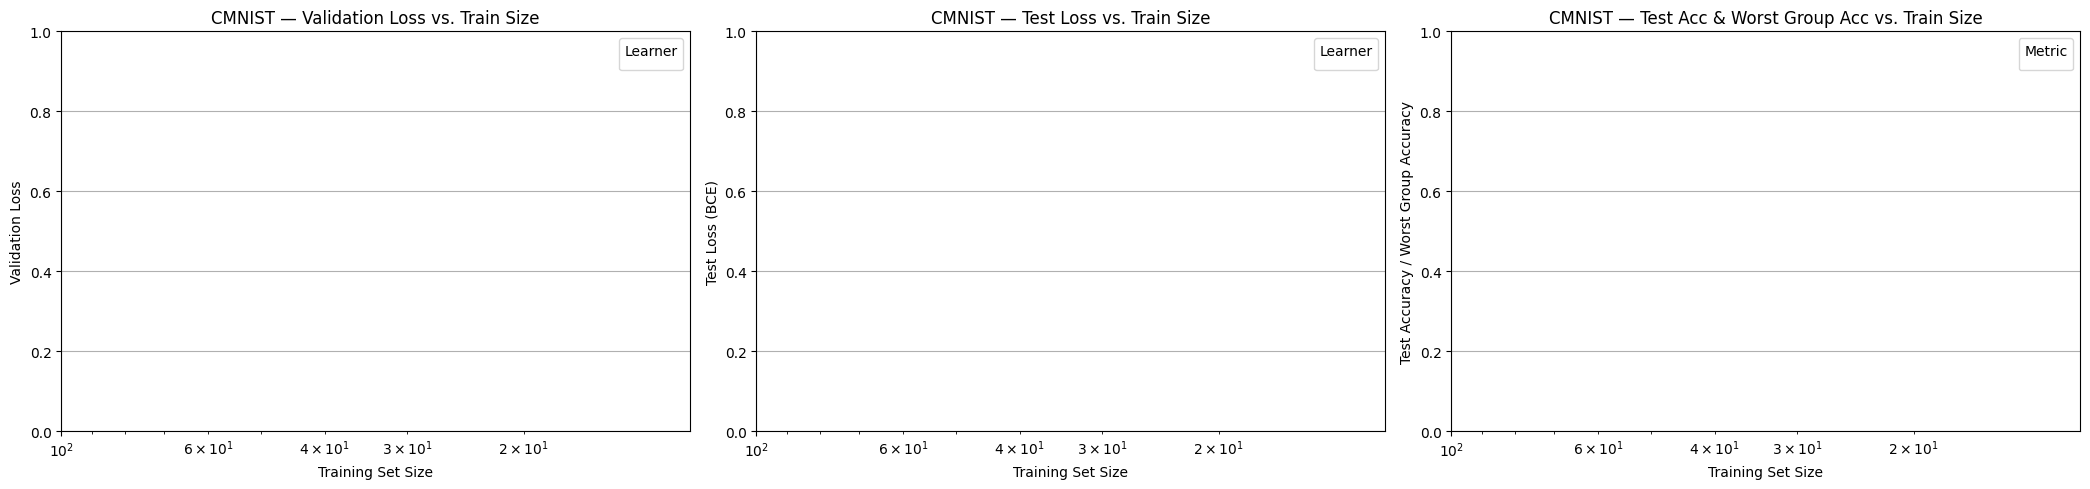


=== Results Summary for CMNIST ===

GroupDRO:
  Valid validation losses: 3/5
  Valid test accuracies: 3/5
  Valid worst group accuracies: 3/5
  Best test accuracy: 0.9851
  Best worst group accuracy: 0.9131

ERM:
  Valid validation losses: 0/5
  Valid test accuracies: 0/5
  Valid worst group accuracies: 0/5

CRT:
  Valid validation losses: 0/5
  Valid test accuracies: 0/5
  Valid worst group accuracies: 0/5

DFR:
  Valid validation losses: 0/5
  Valid test accuracies: 0/5
  Valid worst group accuracies: 0/5

IRM:
  Valid validation losses: 0/5
  Valid test accuracies: 0/5
  Valid worst group accuracies: 0/5

ReSample:
  Valid validation losses: 0/5
  Valid test accuracies: 0/5
  Valid worst group accuracies: 0/5


In [ ]:
# Plot results
import itertools
from subpopbench.utils.plotting import savefig
import warnings

# Helper function to filter out NaN values for plotting
def filter_finite_values(x_vals, y_vals):
    """Filter out NaN/inf values for plotting"""
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)
    
    # Keep only finite values
    finite_mask = np.isfinite(y_vals)
    return x_vals[finite_mask], y_vals[finite_mask]

fig, axes = plt.subplots(1, 3, figsize=(21, 5), sharex=True)

# Get color cycle for consistent coloring
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
alg_colors = {alg: next(color_cycle) for alg in LEARNERS}

# Validation loss
ax = axes[0]
for alg in LEARNERS:
    try:
        if alg in val_loss_map and val_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, val_loss_map[alg])
            if len(x_vals) > 0:
                ax.errorbar(x_vals, y_vals, fmt='-o', capsize=4, label=alg, color=alg_colors[alg])
            else:
                print(f"[Warning] No valid validation loss data for {alg}")
        else:
            print(f"[Warning] No validation loss data found for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot validation loss for {alg}: {e}")

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Validation Loss')
ax.set_xscale('log')
ax.set_xlim(left=min(dataset_sizes))
ax.set_title(f'{DATASET_NAME} — Validation Loss vs. Train Size')
ax.grid(True)
ax.legend(title='Learner')

# Test loss (only overall test loss)
ax2 = axes[1]
for alg in LEARNERS:
    try:
        if alg in test_loss_map and test_loss_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_loss_map[alg])
            if len(x_vals) > 0:
                ax2.errorbar(x_vals, y_vals, fmt='-o', capsize=4, label=f'{alg} Test Loss', color=alg_colors[alg])
            else:
                print(f"[Warning] No valid test loss data for {alg}")
        else:
            print(f"[Warning] No test loss data found for {alg}")
    except Exception as e:
        print(f"[Warning] Failed to plot test loss for {alg}: {e}")

ax2.set_xlabel('Training Set Size')
ax2.set_ylabel('Test Loss (BCE)')
ax2.set_xscale('log')
ax2.set_xlim(left=min(dataset_sizes))
ax2.set_title(f'{DATASET_NAME} — Test Loss vs. Train Size')
ax2.grid(True)
ax2.legend(title='Learner')

# Test accuracy and worst-group accuracy
ax3 = axes[2]
for alg in LEARNERS:
    try:
        # Plot test accuracy
        if alg in test_acc_map and test_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, test_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '-o', label=f'{alg} Test Acc', color=alg_colors[alg], linestyle='-')
            else:
                print(f"[Warning] No valid test accuracy data for {alg}")
        
        # Plot worst group accuracy
        if alg in worst_group_acc_map and worst_group_acc_map[alg]:
            x_vals, y_vals = filter_finite_values(dataset_sizes, worst_group_acc_map[alg])
            if len(x_vals) > 0:
                ax3.plot(x_vals, y_vals, '--s', label=f'{alg} Worst Group Acc', color=alg_colors[alg], linestyle='--')
            else:
                print(f"[Warning] No valid worst group accuracy data for {alg}")
                
    except Exception as e:
        print(f"[Warning] Failed to plot accuracy metrics for {alg}: {e}")

ax3.set_xlabel('Training Set Size')
ax3.set_ylabel('Test Accuracy / Worst Group Accuracy')
ax3.set_xscale('log')
ax3.set_xlim(left=min(dataset_sizes))
ax3.set_title(f'{DATASET_NAME} — Test Acc & Worst Group Acc vs. Train Size')
ax3.grid(True)
ax3.legend(title='Metric')

plt.tight_layout()

# Save figure with error handling
try:
    savefig(f'{DATASET_NAME.lower()}_summary_metrics.png', fig=fig, subdir='pcl')
    print(f"[Info] Plot saved successfully")
except Exception as e:
    print(f"[Warning] Failed to save plot: {e}")
    
plt.show()

# Print summary of results
print(f"\n=== Results Summary for {DATASET_NAME} ===")
for alg in LEARNERS:
    print(f"\n{alg}:")
    try:
        valid_val_losses = [x for x in val_loss_map.get(alg, []) if np.isfinite(x)]
        valid_test_accs = [x for x in test_acc_map.get(alg, []) if np.isfinite(x)]
        valid_worst_accs = [x for x in worst_group_acc_map.get(alg, []) if np.isfinite(x)]
        
        print(f"  Valid validation losses: {len(valid_val_losses)}/{len(dataset_sizes)}")
        print(f"  Valid test accuracies: {len(valid_test_accs)}/{len(dataset_sizes)}")
        print(f"  Valid worst group accuracies: {len(valid_worst_accs)}/{len(dataset_sizes)}")
        
        if valid_test_accs:
            print(f"  Best test accuracy: {max(valid_test_accs):.4f}")
        if valid_worst_accs:
            print(f"  Best worst group accuracy: {max(valid_worst_accs):.4f}")
    except Exception as e:
        print(f"  Error computing summary: {e}")

In [ ]:
_ = group_counts(train_dataset, 'train')
_ = group_counts(val_dataset, 'val')
_ = group_counts(test_dataset, 'test')

[train] size=30000 | unique attrs=[0, 1] | unique labels=[0, 1]
[train] attr counts: {0: 15329, 1: 14671}
[train] label counts: {0: 15331, 1: 14669}
[train] (label, attr) counts: {(0, 0): 13849, (0, 1): 1482, (1, 0): 1480, (1, 1): 13189}
[val] size=2000 | unique attrs=[0, 1] | unique labels=[0, 1]
[val] attr counts: {0: 1034, 1: 966}
[val] label counts: {0: 1037, 1: 963}
[val] (label, attr) counts: {(0, 0): 918, (0, 1): 119, (1, 0): 116, (1, 1): 847}
[test] size=20000 | unique attrs=[0, 1] | unique labels=[0, 1]
[test] attr counts: {0: 10112, 1: 9888}
[test] label counts: {0: 10176, 1: 9824}
[test] (label, attr) counts: {(0, 0): 9157, (0, 1): 1019, (1, 0): 955, (1, 1): 8869}


: 

: 

: 

: 

In [ ]:
# Print error summary and cleanup
print_error_summary()

# Memory cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"\nGPU memory cleared. Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Save results to file for backup
import json
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = f"results_{DATASET_NAME}_{timestamp}.pkl"

try:
    results_data = {
        'dataset_name': DATASET_NAME,
        'learners': LEARNERS,
        'dataset_sizes': dataset_sizes,
        'val_loss_map': val_loss_map,
        'train_loss_map': train_loss_map,
        'test_loss_map': test_loss_map,
        'test_acc_map': test_acc_map,
        'worst_group_acc_map': worst_group_acc_map,
        'error_log': ERROR_LOG,
        'hparams': base_hparams,
        'timestamp': timestamp
    }
    
    with open(results_file, 'wb') as f:
        pickle.dump(results_data, f)
    
    print(f"\nResults saved to: {results_file}")
    
    # Also save a human-readable summary
    summary_file = f"summary_{DATASET_NAME}_{timestamp}.txt"
    with open(summary_file, 'w') as f:
        f.write(f"Experiment Summary - {DATASET_NAME}\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Learners: {LEARNERS}\n")
        f.write(f"Dataset sizes: {dataset_sizes}\n\n")
        
        for alg in LEARNERS:
            f.write(f"\n{alg} Results:\n")
            f.write("-" * 20 + "\n")
            
            for i, size in enumerate(dataset_sizes):
                f.write(f"Size {size}:\n")
                f.write(f"  Val Loss: {val_loss_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Test Acc: {test_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
                f.write(f"  Worst Group Acc: {worst_group_acc_map.get(alg, [float('nan')] * len(dataset_sizes))[i]:.4f}\n")
        
        # Add error summary
        f.write(f"\n\nError Summary:\n")
        f.write("=" * 30 + "\n")
        total_errors = sum(len(errors) for error_dict in ERROR_LOG.values() for errors in error_dict.values())
        f.write(f"Total errors encountered: {total_errors}\n")
        
        for error_type, errors in ERROR_LOG.items():
            if errors:
                f.write(f"\n{error_type.replace('_', ' ').title()}:\n")
                for context, error_list in errors.items():
                    f.write(f"  {context}: {len(error_list)} errors\n")
    
    print(f"Summary saved to: {summary_file}")
    
except Exception as e:
    print(f"Warning: Failed to save results: {e}")

print("\n=== Experiment Complete ===")

: 

: 

: 

: 

In [ ]:
#  jupyter nbconvert --to notebook --execute subpopbench/pcl.ipynb --output executed_notebook.ipynb
# [NbConvertApp] Converting notebook subpopbench/pcl.ipynb to notebook

: 

: 

: 

: 